<a href="https://colab.research.google.com/github/zetta-health/exp-curso-python-saude/blob/master/PySaude_03_python_arvore_regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <a href="https://www.linkedin.com/company/zetta-health-analytics/" align="center"><img src="https://raw.githubusercontent.com/zetta-health/exp-curso-python-saude/master/assets/zetta-exp-logo.jpg" width="400" align="center"></a>

# **Árvores de decisão**
---

Neste notebook faremos um modelo de [árvore de decisão](https://en.wikipedia.org/wiki/Decision_tree_learning) utilizando o módulo [scikit-learn](https://scikit-learn.org/stable/modules/tree.html).

Modelos de árvore de decisão são frequentemente utilizados na área da saúde, sendo úteis para quando as decisões tomadas tem que ser facilmente justificadas, pois é possível visualizar e entender o processo.

## Índice

* [Importando módulos](#imports)
* [1. Carregando os dados](#data)
* [2. Análise exploratória](#analysis)
* [3. Árvore de regressão](#tree)

## **Importando módulos** <a name="imports"></a>

A primeira coisa a ser feita é importar os módulos para termos as funcionalidades de trabalhar com os dados e construir os modelos.

Caso haja algum erro você pode cosultar nosso [Notebook sobre bibliotecas](https://github.com/zetta-health/exp-curso-python-saude/blob/master/PySaude_01_colab_visao_geral_03_bibliotecas.ipynb).

In [0]:
 #!pip install -q dtreeviz

In [0]:
# Trabalhar com os dados
import pandas as pd
import numpy as np
# Criação e avaliação do modelo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from dtreeviz.trees import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


---

## **1. Carregando os dados** <a name="data"></a>

Agora carregamos um dataset de gastos com saúde e alguns atributos relacionados às pessoas que tiveram esses gastos, como idade e sexo por exemplo. Podemos utilizá-los para criar um modelo para prever os custos de alguma pessoa que não está na base de dados.

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/zetta-health/exp-curso-python-saude/master/data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [0]:
df.shape

(1338, 7)

---

## **2. Análise exploratória** <a name='analysis'></a>

Como vimos no nosso notebook de [análise exploratória](https://github.com/zetta-health/exp-curso-python-saude/blob/master/PySaude_03_python_analise_exploratoria_de_dados.ipynb), é bastante comum haver erros no preenchimento de alguns campos como no caso de sexo onde os valores podem vir escritos de formas diferentes, ou faltar alguns valores, como no caso de idade.  
Além disso, é possível que os valores venham com os tipos de dados que precisam ser convertidos, as vezes números podem vir como _objects_ (_strings_), por exemplo.

Precisamos tratar desses problemas antes de realizar qualquer análise e construir algum modelo.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Vamos verificar os valores das colunas `sex`, `smoker` e `region`, que foram carregadas como `object`, sendo categóricas. Isso significa que os valores podem ser letras, númeors, ou uma mistura dos dois.

In [0]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [0]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [0]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

É necessário transformar essas variáveis categóricas em números (_dummies_) para poder utilizá-las nos modelos

In [0]:
X = pd.get_dummies(df.drop('region', axis=1), drop_first=True) # Salvamos o resultado em outra variável
                                        # que será utilizada futuramente

In [0]:
X.head()

,age,bmi,children,charges,sex_male,smoker_yes
0,19,27.900,0,16884.92400,0,1
1,18,33.770,1,1725.55230,1,0
2,28,33.000,3,4449.46200,1,0
3,33,22.705,0,21984.47061,1,0
4,32,28.880,0,3866.85520,1,0


### Qual a idade dos participantes - histograma

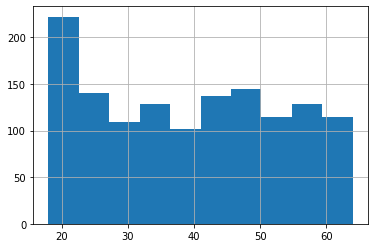

In [0]:
df['age'].hist()

### Distribuição por sexo - gráfico de barras

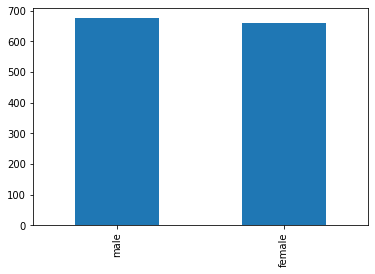

In [0]:
df['sex'].value_counts().plot(kind='bar')

### O índice de massa corporal por sexo? - boxplot

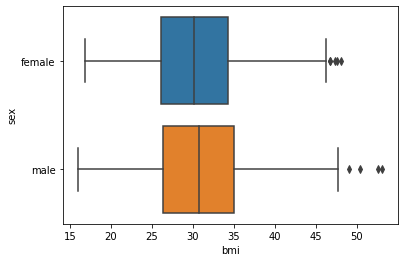

In [0]:
sns.boxplot(x='bmi', y='sex', data=df)

### Sinistro - histograma, medida de tendência central e dispersão

In [0]:
df['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

### Frequência de fumantes? - barras

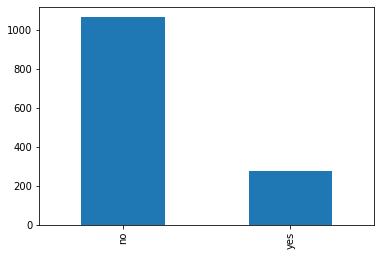

In [0]:
df['smoker'].value_counts().plot(kind='bar')

### Matriz de Correlação

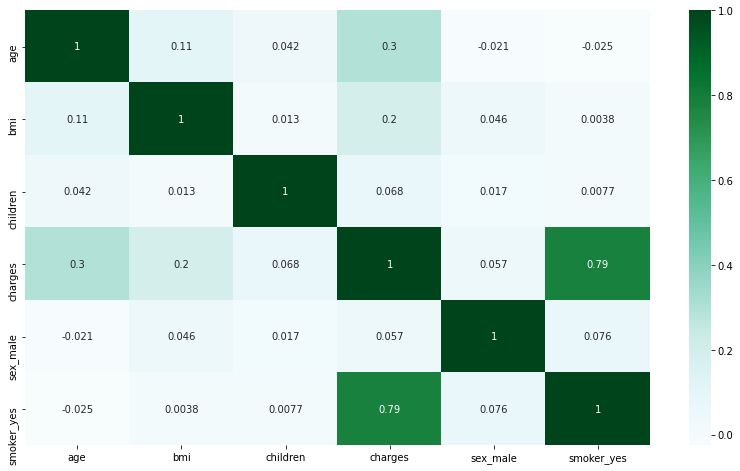

In [0]:
plt.figure(figsize=(14,8))
sns.heatmap(X.corr(), 
            cmap='BuGn', 
            annot=True)

## **3. Árvore de regressão** <a name="tree"></a>

### a. Selecionar variáveis para adicionar ao modelo com base em 2.

In [0]:
X = X[['age', 'bmi', 'smoker_yes']]

y = df['charges']

### b) Split/Train com K-folds

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### c) Selecionar algorítmo e parâmetros, treinar modelo

In [0]:
regr = DecisionTreeRegressor(max_depth=3,
                            min_samples_leaf=20,
                            random_state=0)

In [0]:
regr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

### D) Avaliar métricas do modelo

In [0]:
regr.score(X_test, y_test) # R quadrado

0.8751026719462079

In [0]:
print(cross_val_score(regr, X, y, cv=5))
cross_val_score(regr, X, y, cv=5).mean() # média

[0.8782583  0.78176659 0.88089714 0.82756408 0.85377766]


0.8444527540517217

### E) Visualizar modelo de regressão

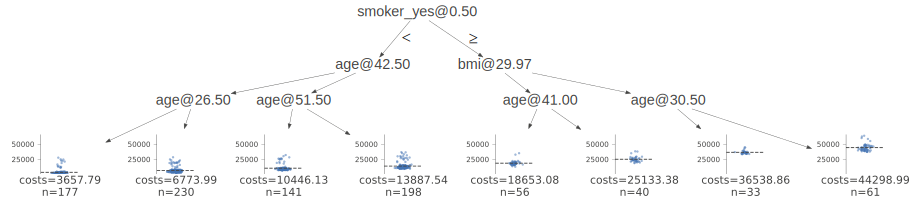

In [0]:
viz = dtreeviz(regr,
               X_train,
               y_train,
               target_name='costs',
               feature_names=X.columns.values,
               fancy=False,
               scale=1.2)

viz

# **Yey! Parabéns por ter completado este notebook!**

Este notebook faz parte do curso de *Introdução ao Python para Análise de Dados em Saúde*, oferecido pela [Zetta Exponential](https://www.linkedin.com/company/zetta-health-analytics/) e Universidade Federal de Viçosa, e for escrito por:

* [Gabriel Kakizaki](https://www.linkedin.com/in/gabriel-kakizaki-25b6311a5/): graduando em Administração pela Universidade Federal de Viçosa, membro do PET-ADM e estagiário na Zetta Exponential. 

* [Ana Flávia Santos](https://www.linkedin.com/in/ana-fl%C3%A1via-santos-2b06151a5/): graduanda em Economia pela Universidade Federal de Viçosa e estagiária na Zetta Exponential.

---
Copyright 2020, Zetta Exponential
